In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import collections
from tqdm import tqdm
sns.set()

In [2]:
def build_dataset(words, n_words, atleast=1):
    count = [['PAD', 0], ['GO', 1], ['EOS', 2], ['UNK', 3]]
    counter = collections.Counter(words).most_common(n_words)
    counter = [i for i in counter if i[1] >= atleast]
    count.extend(counter)
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        index = dictionary.get(word, 0)
        if index == 0:
            unk_count += 1
        data.append(index)
    count[0][1] = unk_count
    reversed_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return data, count, dictionary, reversed_dictionary

In [3]:
with open('shakespeare.txt') as fopen:
    shakespeare = fopen.read()

In [4]:
vocabulary_size = len(list(set(shakespeare)))
data, count, dictionary, rev_dictionary = build_dataset(shakespeare, vocabulary_size)

In [5]:
GO = dictionary['GO']
PAD = dictionary['PAD']
EOS = dictionary['EOS']
UNK = dictionary['UNK']

In [6]:
class Generator:
    def __init__(self, size_layer, num_layers, embedded_size,
                 from_dict_size, to_dict_size, learning_rate, batch_size):
        
        def cells(reuse=False):
            return tf.nn.rnn_cell.GRUCell(size_layer,reuse=reuse)
        
        self.X = tf.placeholder(tf.int32, [None, None])
        self.Y = tf.placeholder(tf.int32, [None, None])
        self.X_seq_len = tf.count_nonzero(self.X, 1, dtype=tf.int32)
        self.Y_seq_len = tf.count_nonzero(self.Y, 1, dtype=tf.int32)
        batch_size = tf.shape(self.X)[0]
        
        encoder_embedding = tf.Variable(tf.random_uniform([from_dict_size, embedded_size], -1, 1))
        decoder_embedding = tf.Variable(tf.random_uniform([to_dict_size, embedded_size], -1, 1))
        self.cells = tf.nn.rnn_cell.MultiRNNCell([cells() for _ in range(num_layers)])
        self.encoder_state = self.cells.zero_state(
            dtype = tf.float32, batch_size = tf.shape(self.X)[0]
        )
        
        _, encoder_state = tf.nn.dynamic_rnn(
            cell = self.cells, 
            inputs = tf.nn.embedding_lookup(encoder_embedding, self.X),
            sequence_length = self.X_seq_len,
            initial_state = self.encoder_state,
            dtype = tf.float32)
        main = tf.strided_slice(self.Y, [0, 0], [batch_size, -1], [1, 1])
        decoder_input = tf.concat([tf.fill([batch_size, 1], GO), main], 1)
        dense = tf.layers.Dense(to_dict_size)
        decoder_cells = tf.nn.rnn_cell.MultiRNNCell([cells() for _ in range(num_layers)])
        
        training_helper = tf.contrib.seq2seq.TrainingHelper(
                inputs = tf.nn.embedding_lookup(decoder_embedding, decoder_input),
                sequence_length = self.Y_seq_len,
                time_major = False)
        training_decoder = tf.contrib.seq2seq.BasicDecoder(
                cell = decoder_cells,
                helper = training_helper,
                initial_state = encoder_state,
                output_layer = dense)
        training_decoder_output, self.training_state, _ = tf.contrib.seq2seq.dynamic_decode(
                decoder = training_decoder,
                impute_finished = True,
                maximum_iterations = tf.reduce_max(self.Y_seq_len))
        self.training_logits = training_decoder_output.rnn_output
        
        predicting_helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(
                embedding = decoder_embedding,
                start_tokens = tf.tile(tf.constant([GO], dtype=tf.int32), [batch_size]),
                end_token = EOS)
        predicting_decoder = tf.contrib.seq2seq.BasicDecoder(
                cell = decoder_cells,
                helper = predicting_helper,
                initial_state = encoder_state,
                output_layer = dense)
        predicting_decoder_output, self.predict_state, _ = tf.contrib.seq2seq.dynamic_decode(
                decoder = predicting_decoder,
                impute_finished = True,
                maximum_iterations = tf.reduce_max(self.X_seq_len))
        self.predicting_ids = predicting_decoder_output.sample_id
        print(self.training_state, self.predict_state)
        
        masks = tf.sequence_mask(self.Y_seq_len, tf.reduce_max(self.Y_seq_len), dtype=tf.float32)
        self.cost = tf.contrib.seq2seq.sequence_loss(logits = self.training_logits,
                                                     targets = self.Y,
                                                     weights = masks)
        self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)
        
        y_t = tf.argmax(self.training_logits,axis=2)
        y_t = tf.cast(y_t, tf.int32)
        self.prediction = tf.boolean_mask(y_t, masks)
        mask_label = tf.boolean_mask(self.Y, masks)
        correct_pred = tf.equal(self.prediction, mask_label)
        correct_index = tf.cast(correct_pred, tf.float32)
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [7]:
learning_rate = 0.001
batch_size = 32
sequence_length = 64
epoch = 3000
num_layers = 2
size_layer = 256
possible_batch_id = range(len(data) - sequence_length - 1)

In [8]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Generator(size_layer, num_layers, size_layer, len(dictionary), 
                len(dictionary), learning_rate,batch_size)
sess.run(tf.global_variables_initializer())

(<tf.Tensor 'decoder/while/Exit_4:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'decoder/while/Exit_5:0' shape=(?, 256) dtype=float32>) (<tf.Tensor 'decoder_1/while/Exit_4:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'decoder_1/while/Exit_5:0' shape=(?, 256) dtype=float32>)


In [9]:
def train_random_batch():
    LOST, ACCURACY = [], []
    pbar = tqdm(range(epoch), desc = 'epoch')
    batch_x = np.zeros((batch_size, sequence_length))
    for n in range(batch_size):
        index = np.random.randint(0, len(data) - sequence_length - 1)
        batch_x[n] = data[index:index + sequence_length]
    initial_state = sess.run(model.predict_state, feed_dict = {model.X: batch_x})
    for i in pbar:
        batch_x = np.zeros((batch_size, sequence_length))
        batch_y = np.zeros((batch_size, sequence_length + 1))
        for n in range(batch_size):
            index = np.random.randint(0, len(data) - sequence_length - 1)
            batch_x[n] = data[index:index + sequence_length]
            batch_y[n] = data[index + 1:index + sequence_length + 1] + [EOS]
        accuracy, _, loss, initial_state = sess.run([model.accuracy, model.optimizer, 
                                                     model.cost, model.predict_state], 
                                       feed_dict = {model.X: batch_x, 
                                                    model.Y: batch_y,
                                                    model.encoder_state: initial_state})
        ACCURACY.append(accuracy); LOST.append(loss)
        pbar.set_postfix(cost = loss, accuracy = accuracy)
    return LOST, ACCURACY

In [10]:
LOST, ACCURACY = train_random_batch()

epoch: 100%|██████████| 3000/3000 [07:16<00:00,  7.02it/s, accuracy=0.744, cost=0.806]


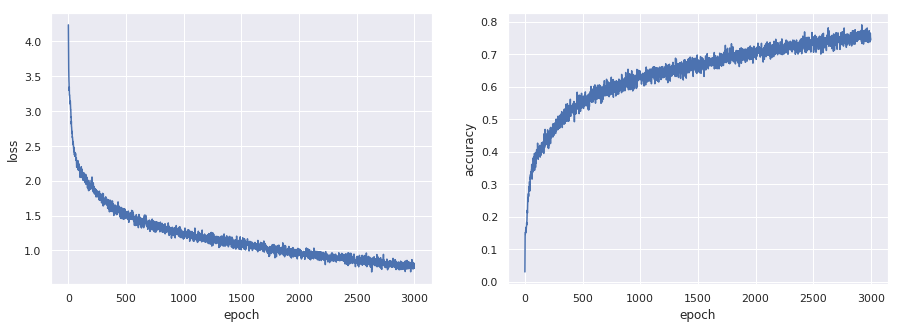

In [11]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
EPOCH = np.arange(len(LOST))
plt.plot(EPOCH, LOST)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.subplot(1, 2, 2)
plt.plot(EPOCH, ACCURACY)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [12]:
def generate_based_sequence(length_sentence):
    index = np.random.randint(0, len(data) - sequence_length - 1)
    x = np.array([data[index:index + sequence_length]])
    initial_state, ids = sess.run([model.predict_state,model.predicting_ids], 
                                  feed_dict = {model.X: x})
    ids = ids[0].tolist()

    while len(ids) < length_sentence:
        initial_state, ids_ = sess.run([model.predict_state,model.predicting_ids], 
                                      feed_dict = {model.X: [ids[-sequence_length:]],
                                                  model.encoder_state: initial_state})
        ids.extend(ids_[0].tolist())

    return ''.join([rev_dictionary[i] for i in ids])

In [13]:
print(generate_based_sequence(1000))

 te houge you not.

DUKE OF YORK:
See, good men, the means of mythe goue you not.

DUKE OF YORK:
Speak, good men, the most fair he goue you not.

DUKE OF YORK:
Speak, good mean, to my bread the goue you not.

DUKE VINCENTIO:
Speak, good mean, for the man b goue you knon
To please. Go, give me of good, and the mouble
Thgoue you know me.

GLOUCESTER:
I plove, I plant me the poor fathou undey thou go.

GLOUCESTER:
I plant, I plead me to her face ou undey though of
peague, I plant. God plant me be the mouth, an undey though off
peage, good and place of pale the people,
Thatyned youth good people,
Baganion pale bold, and the people may wned yout good peecedo,
My power, and place and place the people,ed youg to pedge,
people, power palace, and place and peace the d you got peed,
people, poor place, and pale and place and here  you pot peed,
people, poor place, and pale and partle peace,
Thyou pot peep,
poor, people, poor place, and appear and peace theou ppot peop,
peror, poolight, poor peac